In [75]:
%matplotlib inline

import underworld as uw
import glucifer.pylab as plt
import underworld.function as fn

In [76]:
mesh = uw.mesh.FeMesh_Cartesian('Q1', (1024,128), (0.,0.), (8.,1.))
temperatureField = uw.fevariable.FeVariable(mesh,1)
coord = fn.input()

In [77]:
print mesh.specialSets.keys()  

['MaxI_VertexSet', 'MinI_VertexSet', 'AllWalls', 'MinJ_VertexSet', 'MaxJ_VertexSet', 'Empty']


In [78]:
# declare which nodes are to be considered as boundary nodes
topNodes = mesh.specialSets["MaxJ_VertexSet"] 
bottomNodes = mesh.specialSets["MinJ_VertexSet"]
conditions = uw.conditions.DirichletCondition(temperatureField, topNodes + bottomNodes)


In [91]:
help(uw.conditions)

Help on package underworld.conditions in underworld:

NAME
    underworld.conditions - Implementation relating to imposed conditions.

FILE
    /Applications/underworld2/underworld/conditions/__init__.py

PACKAGE CONTENTS
    _dirichletCondition




In [79]:
# init tempfield to zero everywhere
temperatureField.data[:,0]= 0.0 ## 1.0 - mesh.data[:,1]**2

# setup required values on boundary nodes
temperatureField.data[topNodes.data]    = 0.
temperatureField.data[bottomNodes.data] = 0.

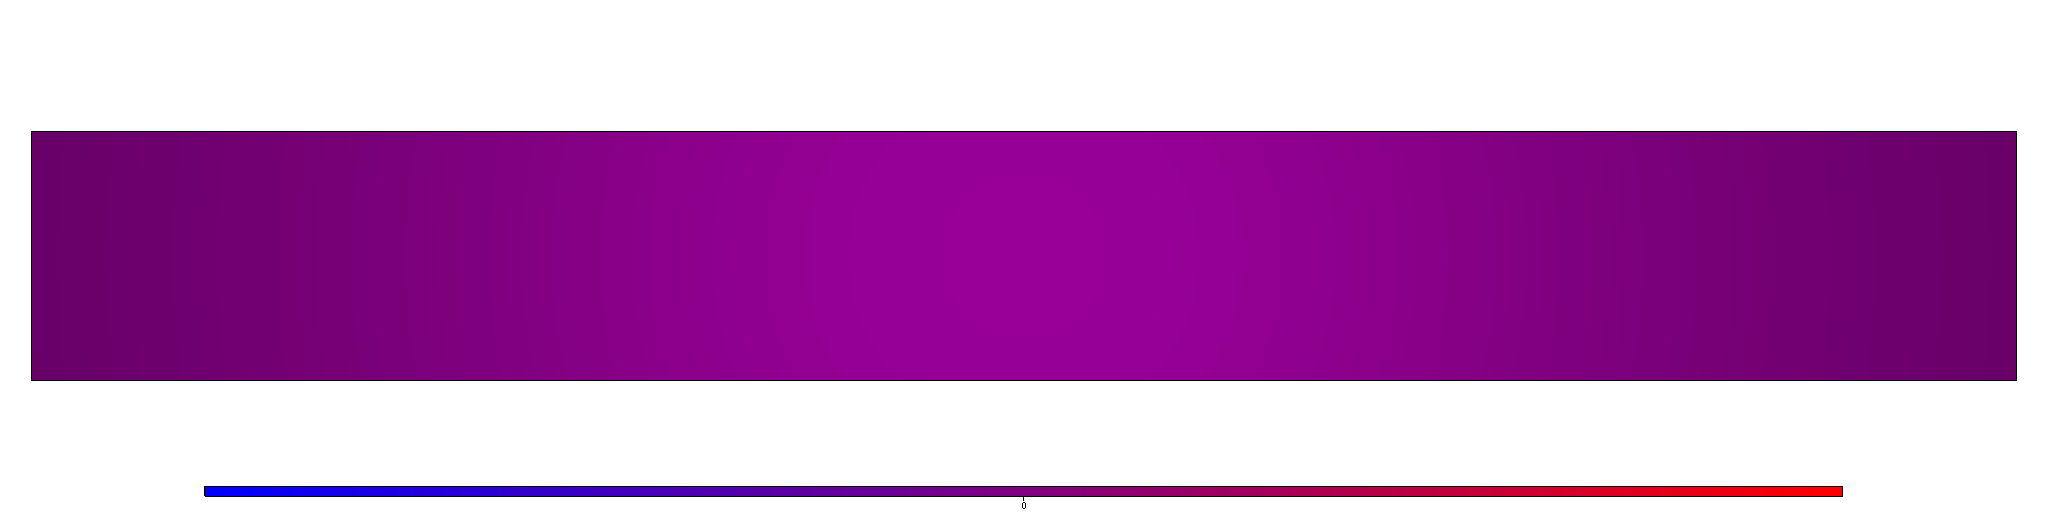

In [80]:
# lets take a look
fig = plt.Figure(figsize=(2048,512))
fig.Surface(temperatureField,mesh, colours=['blue','red'])
fig.show()

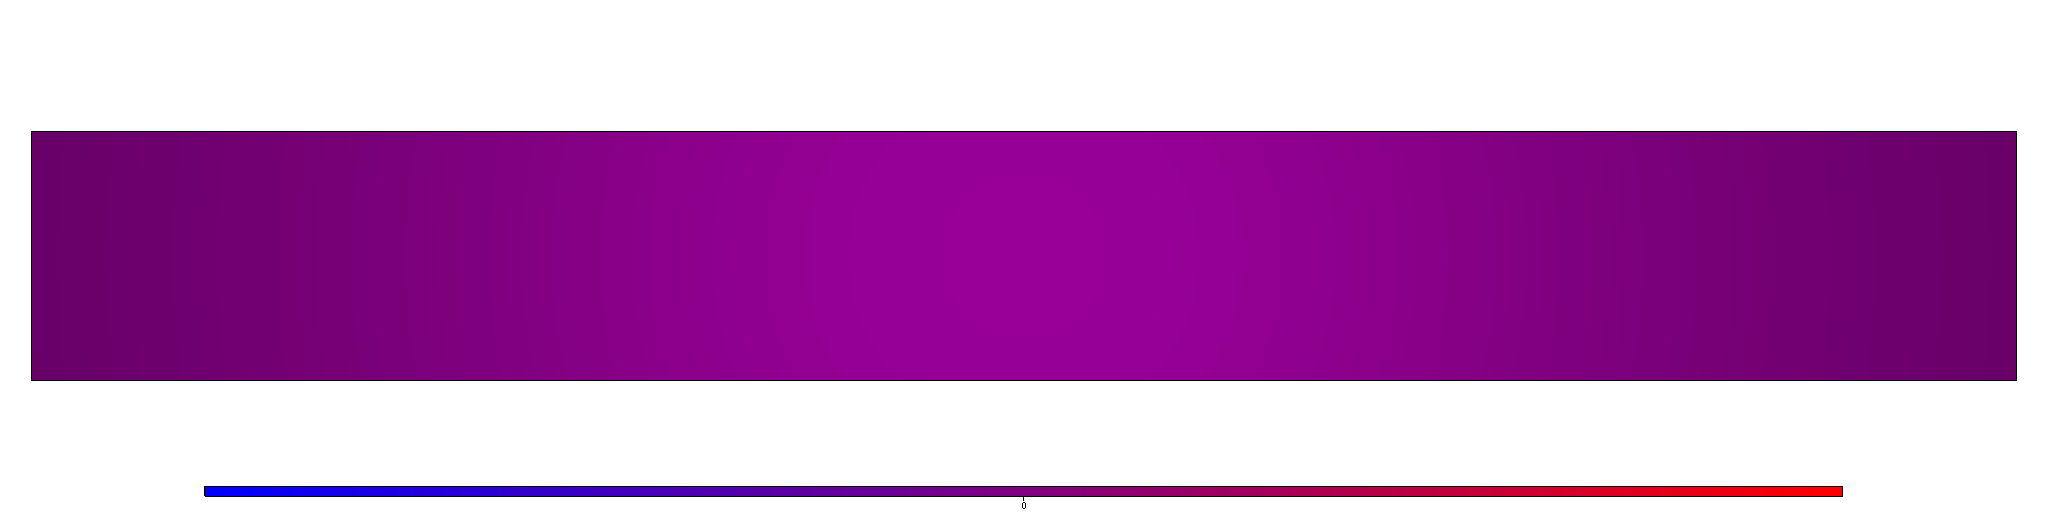

In [81]:
# setup system
steadyStateThermal = uw.systems.SteadyStateHeat(temperatureField,1.,conditions=[conditions,])
# solve!
steadyStateThermal.solve()
# now lets look
fig = plt.Figure(figsize=(2048,512))
fig.Surface(temperatureField,mesh, colours=['blue','red'])
fig.show()

In [82]:
# ok, lets introduce a swarm to set some materials
swarm = uw.swarm.Swarm(mesh)

# lets create a variable which will track the material index
index = swarm.add_variable('char',1)

# add particles
layout = uw.swarm.layouts.GlobalSpaceFillerLayout(swarm,20)
swarm.populate_using_layout(layout)
print "Particles in swarm: ", swarm.particleLocalCount

Particles in swarm:  2621440


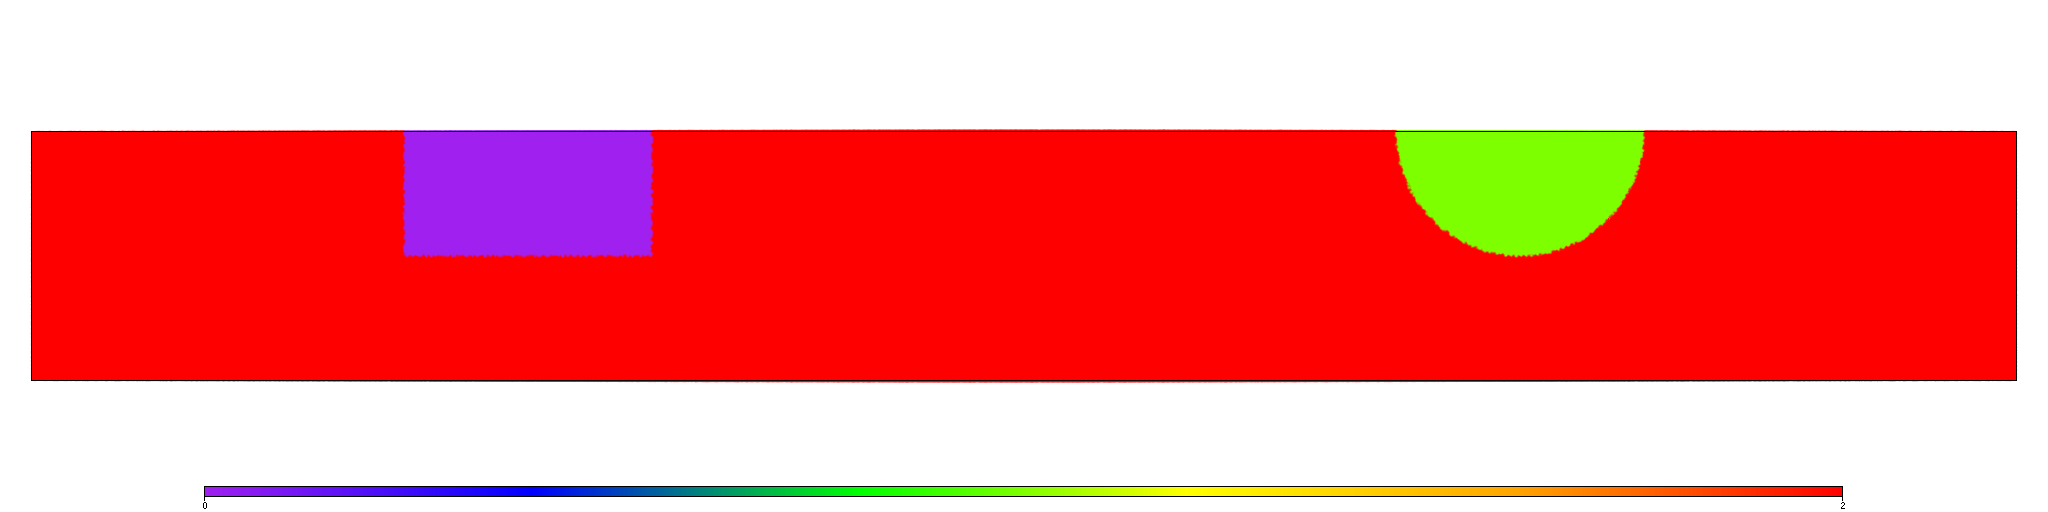

In [83]:
# create some misc shapes
index.data[:] = fn.branching.conditional( [  
        ( (fn.math.abs(coord[0]-2.0) < 0.5) & (fn.math.abs(coord[1]-1.)< 0.50)      , 0),  # square index is 0   
        ( (coord[0]-6.0)*(coord[0]-6.0) + (coord[1]-1.)*(coord[1]-1.) < 0.25        , 1),  # circle index is 1
        ( True                                                                      , 2)   # else index is 2
    ] ).evaluate(swarm)

fig = plt.Figure(figsize=(2048,512))
fig.Points(swarm, index, pointSize=2.0, logScale=False)
fig.show()

In [84]:
# now lets map them to some internal heat production values
internalHeatProductionFunction = fn.branching.map(keyFunc=index, mappingDict={0:1., 1:1., 2:1.})

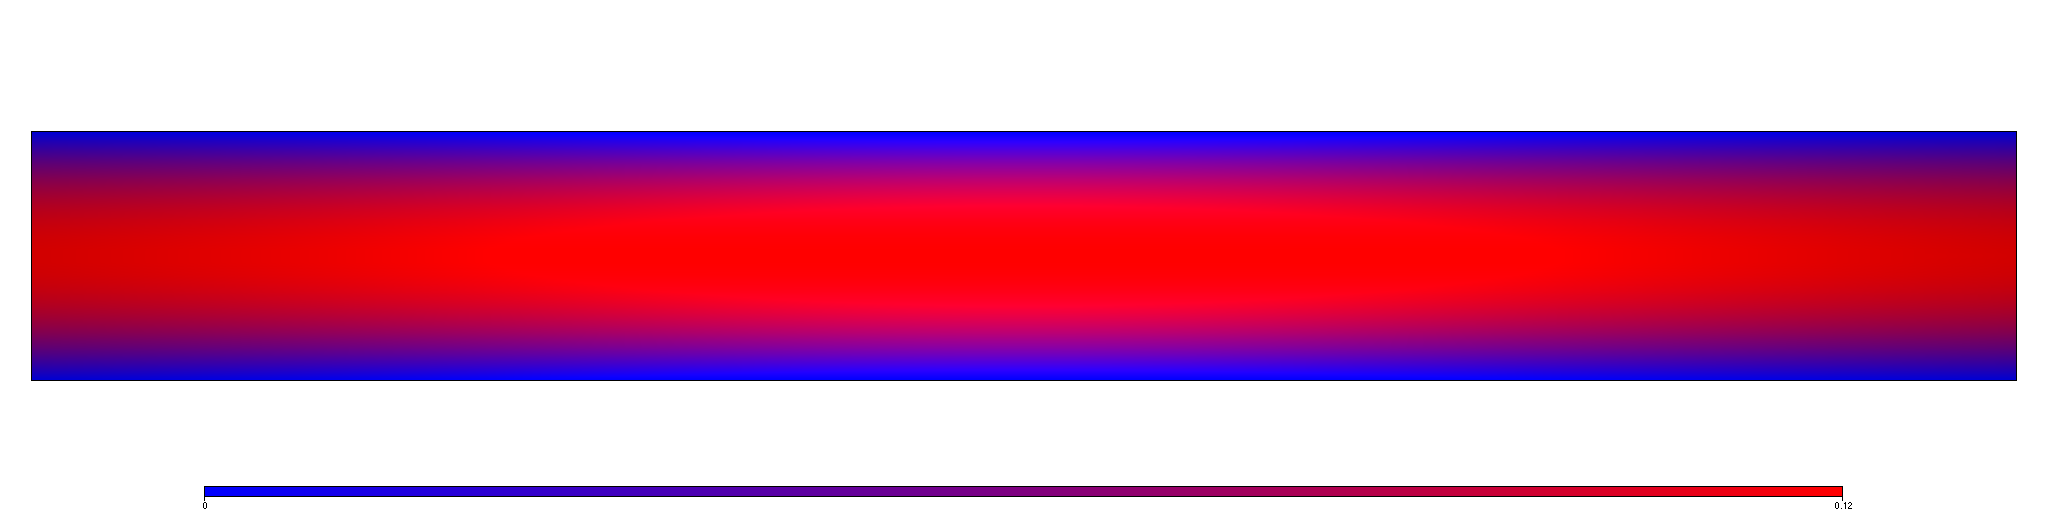

In [85]:
steadyStateThermal.heatingFn = internalHeatProductionFunction
steadyStateThermal.solve()

fig = plt.Figure(figsize=(2048,512))
fig.Surface(temperatureField,mesh, colours=['blue','red'])
fig.show()

In [86]:
#help(steadyStateThermal)

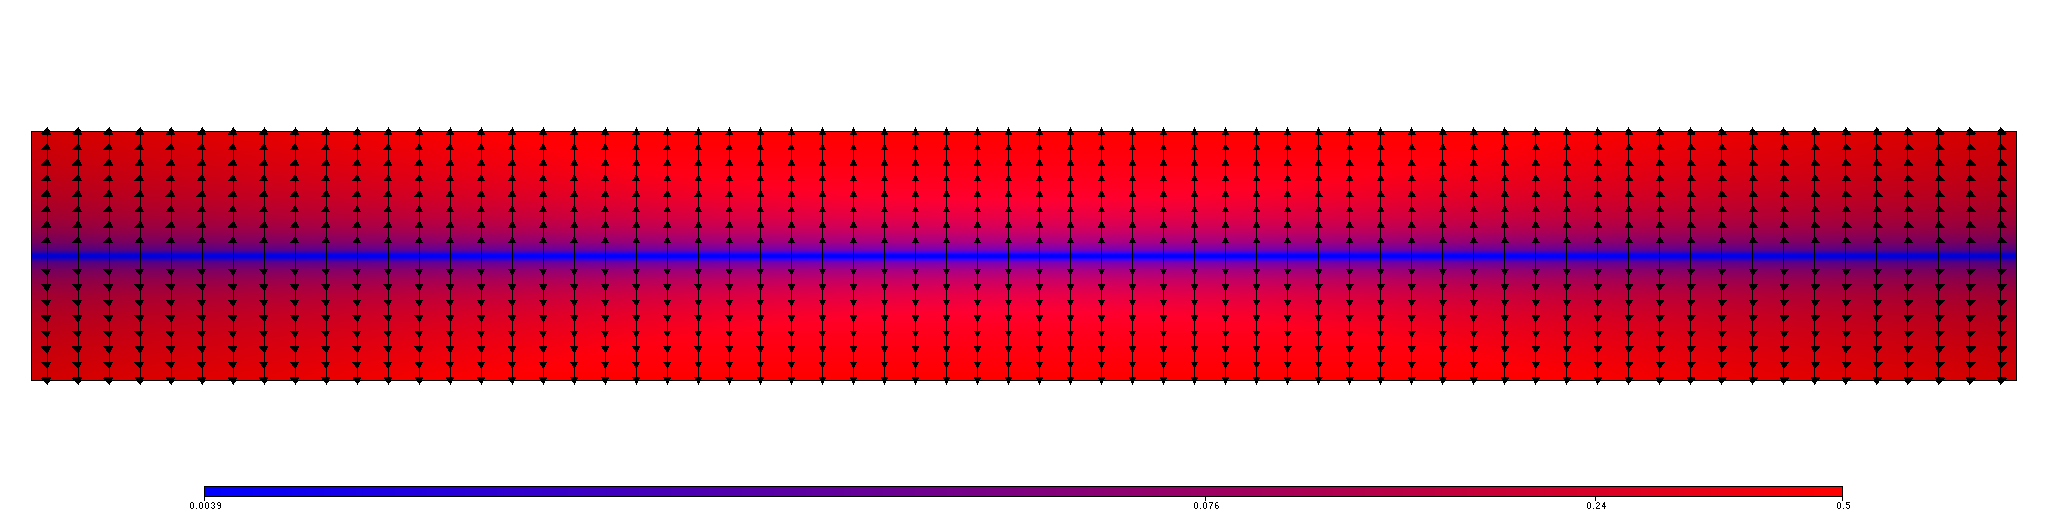

In [87]:
heat_flux_Fn = -temperatureField.gradientFn
heat_flux_magnitude_Fn = fn.math.sqrt(fn.math.dot(heat_flux_Fn, heat_flux_Fn))
heat_flux_norm_Fn = heat_flux_Fn / heat_flux_magnitude_Fn

fig = plt.Figure(figsize=(2048,512))
fig.VectorArrows(heat_flux_norm_Fn, mesh, lengthScale=0.1, resolutionX=64)
fig.Surface(heat_flux_magnitude_Fn,mesh, colours=['blue','red'], logScale=True)
# fig.Surface(temperatureField,mesh, colours=['blue','red'], logScale=False)

fig.show()

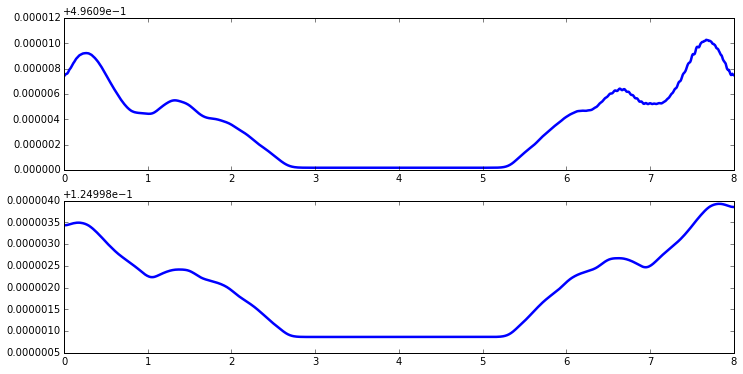

In [88]:
import matplotlib.pyplot as pyplot
from matplotlib import cm
import numpy as np

sample_points_surface   = np.empty((1000,2))
sample_points_surface[:,0] = np.linspace(0.0,8.0,1000)
sample_points_surface[:,1] = 1.0

sample_points_mid_level = sample_points_surface.copy()
sample_points_mid_level[:,1] = 0.5

vertical_temp_grad = heat_flux_Fn.evaluate(sample_points_surface).T[1]
temperature_slice = temperatureField.evaluate(sample_points_mid_level)

figure, (plot1, plot2) = pyplot.subplots(2,1)
figure.set_size_inches(12,6)
plot1.plot(sample_points_surface[:,0], vertical_temp_grad, linewidth=2.5)
plot2.plot(sample_points_mid_level[:,0], temperature_slice, linewidth=2.5)

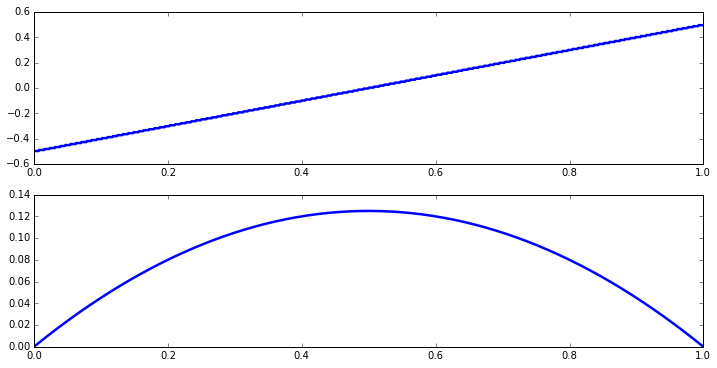

In [90]:
sample_points_vert_mid = np.empty((1000,2))
sample_points_vert_mid[:,1] = np.linspace(0.0,1.0,1000)
sample_points_vert_mid[:,0] = 4.0

temp_grad = heat_flux_Fn.evaluate(sample_points_vert_mid).T[1]
vert_temp_slice = temperatureField.evaluate(sample_points_vert_mid)

figure, (plot1, plot2) = pyplot.subplots(2,1)
figure.set_size_inches(12,6)
plot1.plot(sample_points_vert_mid[:,1], temp_grad, linewidth=2.5)
plot2.plot(sample_points_vert_mid[:,1], vert_temp_slice, linewidth=2.5)